# 1. Import libraries and describe data

In [61]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb


In [62]:
# Load the dataset, parse dates and sort by index
df = pd.read_csv('PJME_hourly.csv', parse_dates=True, index_col=0)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [63]:
# Tail of the dataset to check the last few entries
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


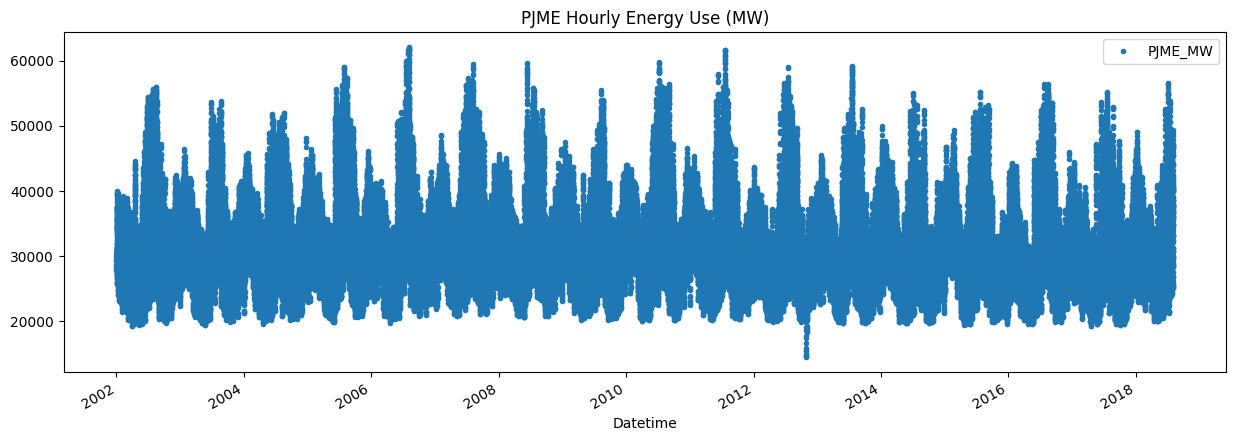

In [64]:
# plot the raw data
df.plot(figsize=(15, 5), 
        style='.', 
        title='PJME Hourly Energy Use (MW)')
plt.show()

In [65]:
# Check information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


# 2. Feature Engineering

In [66]:
# create_time_features function to extract time-based features from the DataFrame index

def create_time_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    return df 

df = create_time_features(df)

# 3. Visualize the data/ EDA

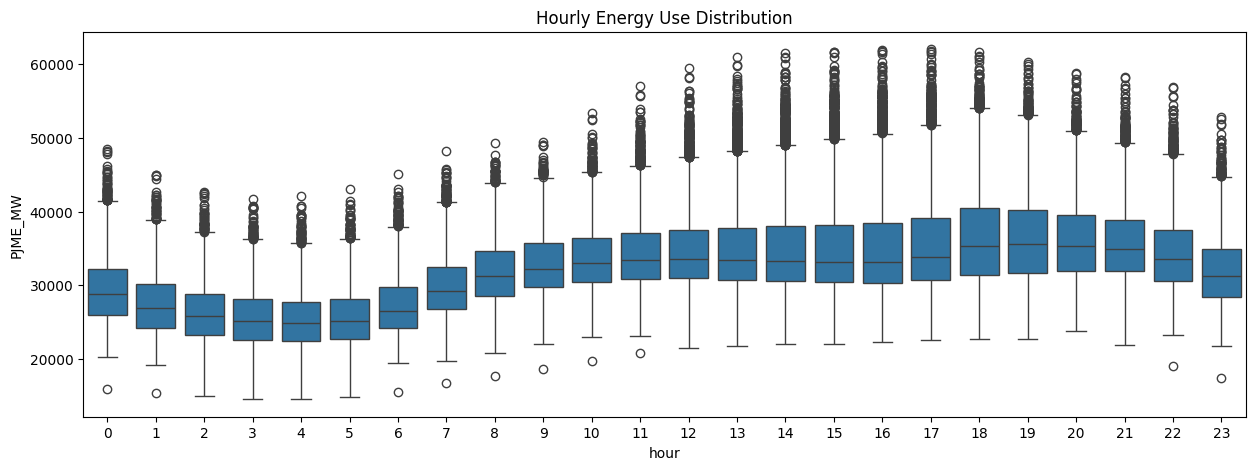

In [67]:
# Visualize the distribution of energy use by hour

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='hour', y='PJME_MW', data=df)
ax.set_title('Hourly Energy Use Distribution')
plt.show()

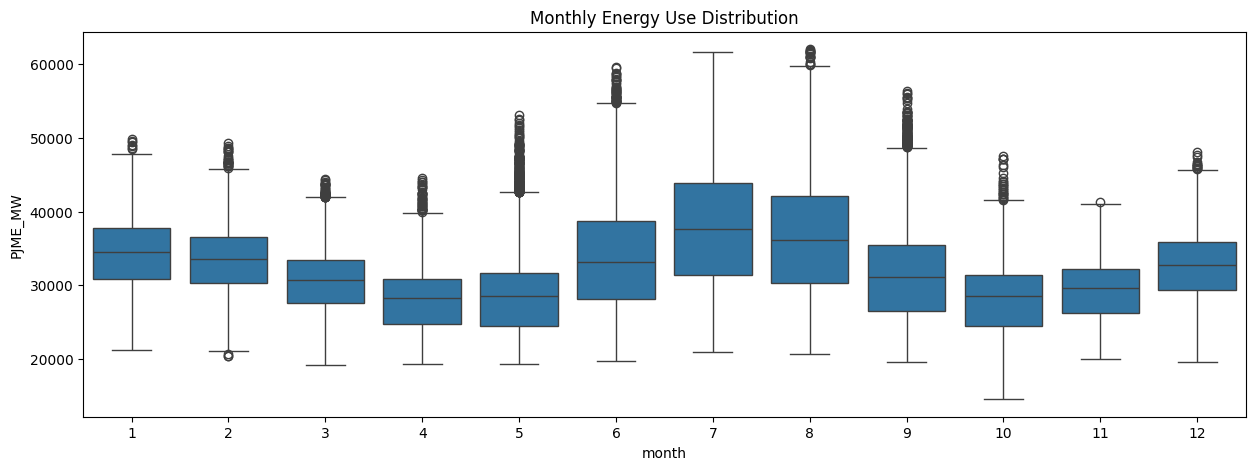

In [68]:
# Visualize the distribution of energy use by month
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='month', y='PJME_MW', data=df, ax=ax)
ax.set_title('Monthly Energy Use Distribution')
plt.show()

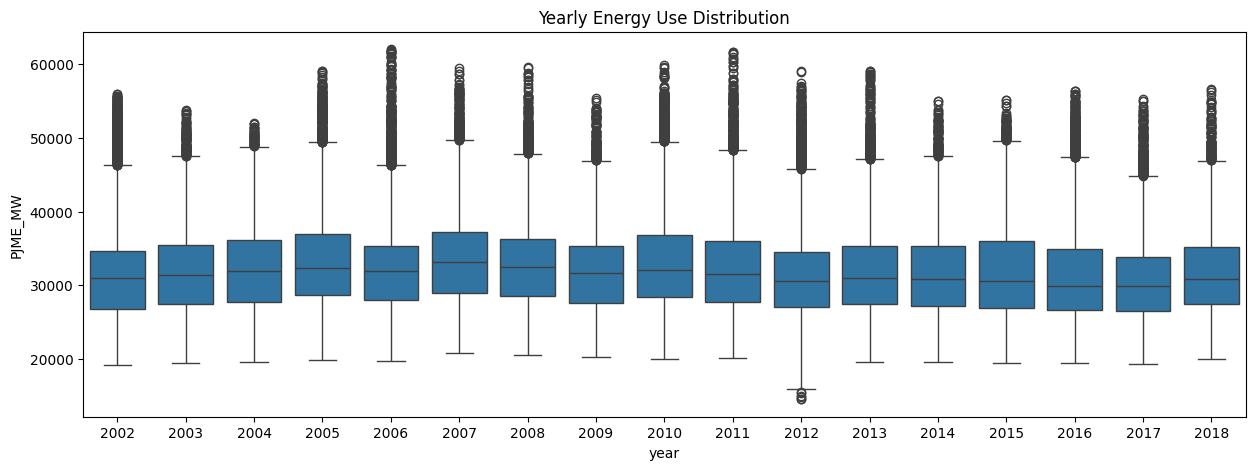

In [69]:
# Visualize the distribution of energy use by year
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='year', y='PJME_MW', data=df, ax=ax)
ax.set_title('Yearly Energy Use Distribution')
plt.show()

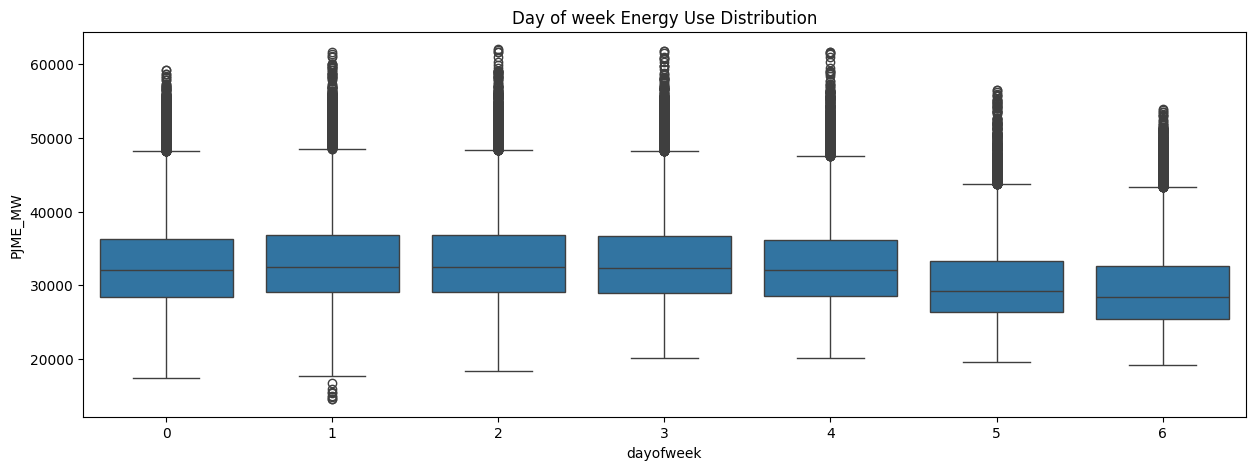

In [70]:
# Visualize the distribution of energy use by day of the week
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='dayofweek', y='PJME_MW', data=df, ax=ax)
ax.set_title('Day of week Energy Use Distribution')
plt.show()

# 4. Outlier Analysis

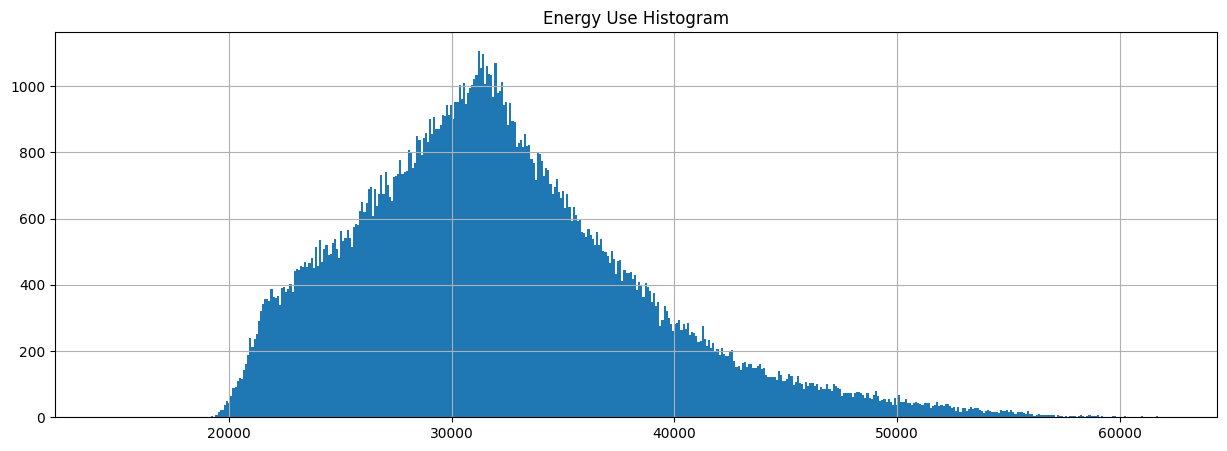

In [71]:
# Create a histogram of energy use
fig, ax = plt.subplots(figsize=(15, 5))
df['PJME_MW'].hist(bins=500, ax=ax)
ax.set_title('Energy Use Histogram')
plt.show()


<Axes: title={'center': 'Energy Use < 20000'}, xlabel='Datetime'>

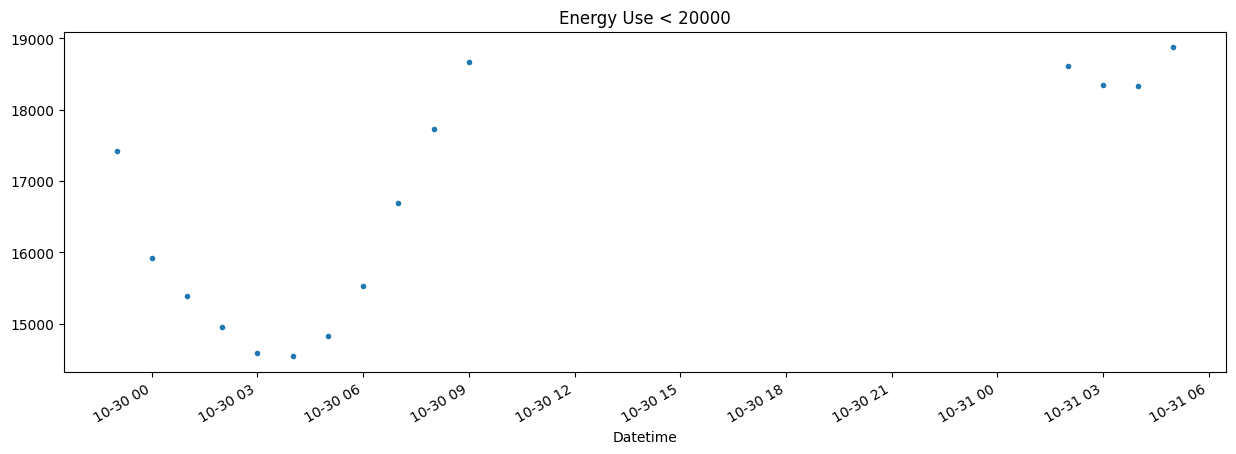

In [72]:
# Check for values < than 20000
df.query('PJME_MW < 19000')['PJME_MW'].plot(style='.', figsize=(15, 5), title='Energy Use < 20000')

- You can also use standard deviation to filter outliers. But here we are using a visualization approach. This might be more intuitive for understanding the data distribution often and better than a heuristic approach if you're doing a custom forecasting.   

In [73]:
# Remove outliers by filtering out values below 19000
df = df.query('PJME_MW >= 19000')

<Axes: title={'center': 'Energy Use < 20000'}, xlabel='Datetime'>

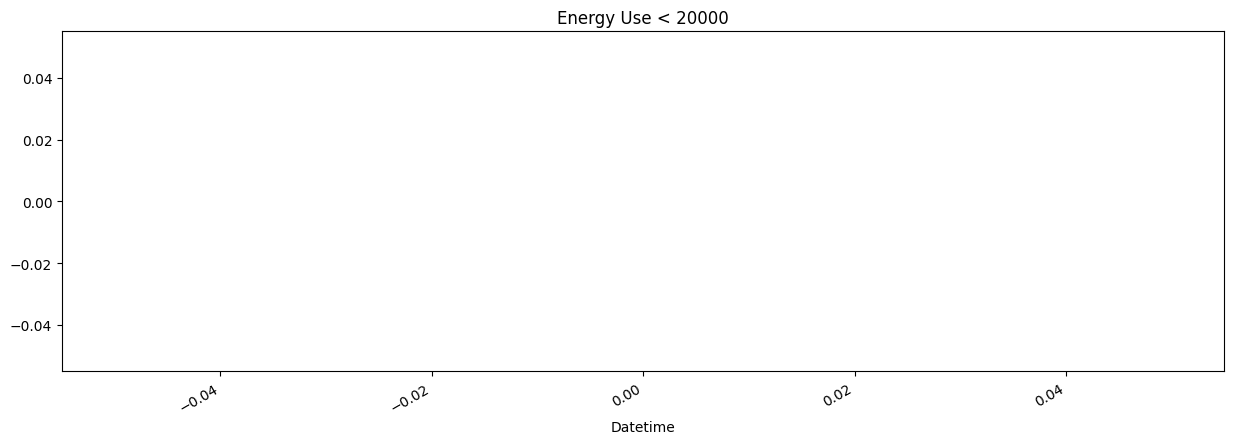

In [74]:
# Check the data again after removing outliers
df.query('PJME_MW <19000')['PJME_MW'].plot(style='.', figsize=(15, 5), title='Energy Use < 20000')

In [75]:
from sklearn.model_selection import TimeSeriesSplit

# Create a time series split object
t_split = TimeSeriesSplit(n_splits = 5,
                        test_size = 24*365*1, # 1 year of data)
                        gap = 24)

df = df.sort_index()
t_split

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

In [76]:
# Iterate through the splits and print the train and test sizes
print("Train-Test Split Sizes:")
for train_index, val_index in t_split.split(df):
    print(f"TRAIN: {train_index.shape}, TEST: {test_index.shape}")

Train-Test Split Sizes:


NameError: name 'test_index' is not defined

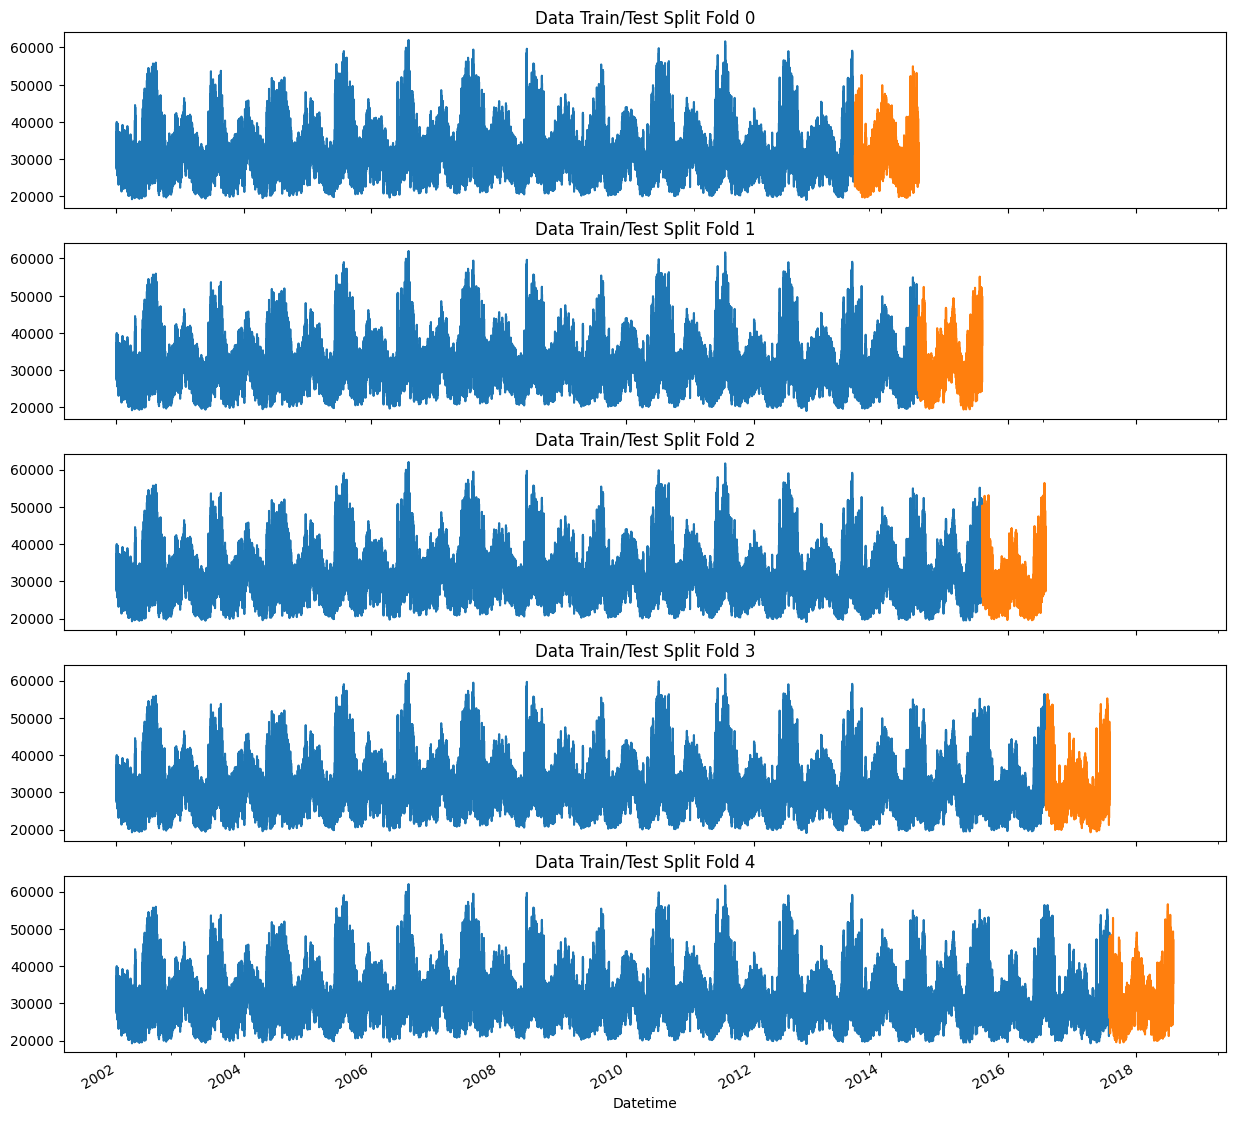

In [77]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in t_split.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    # axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 5. Train-test split

In [78]:
# Split the dataset into training and testing sets
# Using data before 2015 for training and data from 2015 onwards for testing
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

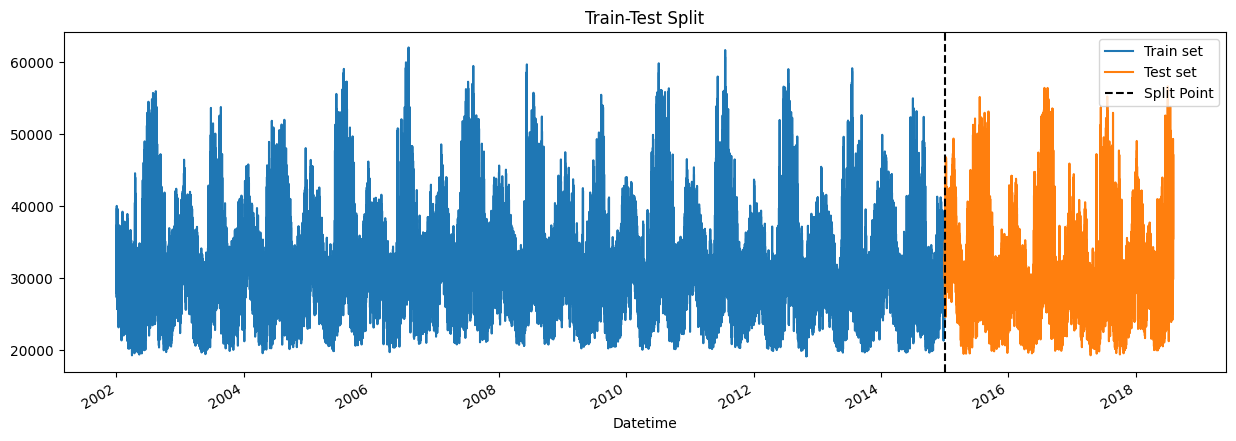

In [79]:
# Visualize the train-test split
fix, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Train set')
test['PJME_MW'].plot(ax=ax, label='Test set')
ax.set_title('Train-Test Split')
ax.axvline('01-01-2015', color='black', linestyle='--', label='Split Point')
ax.legend(['Train set', 'Test set', 'Split Point'])
plt.show()


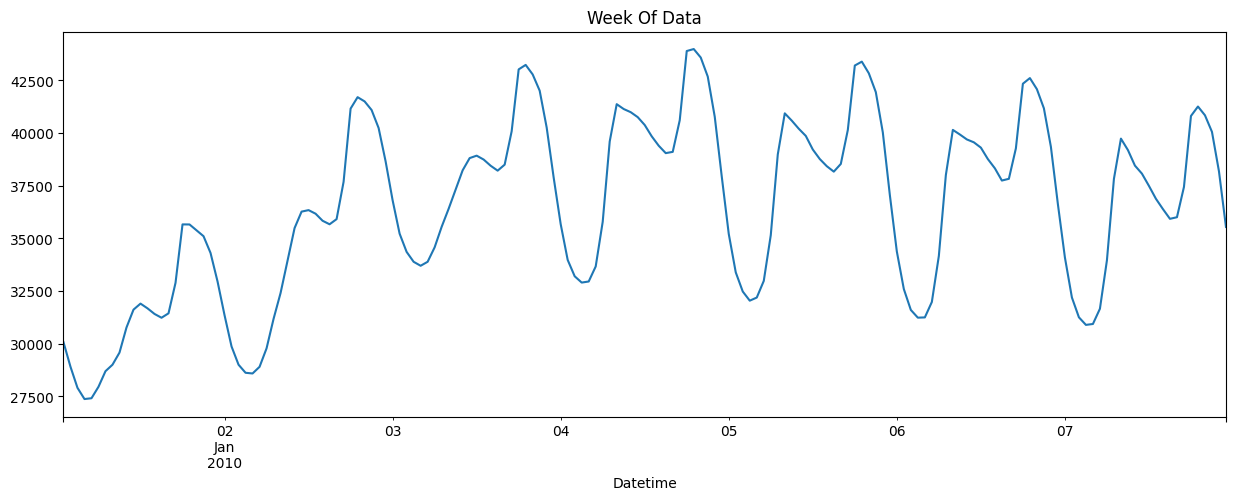

In [80]:
# Visualize a week of data
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# 6. Create and train the model

In [81]:
# Create time features for train and test datasets
train = create_time_features(train)
test = create_time_features(test)

In [82]:
# Check the columns of the DataFrame
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'day', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [83]:
# Define features and target variable
features = ['hour', 'dayofweek', 'quarter', 'day', 'month', 'year']
target = 'PJME_MW'

In [84]:
# Define the features and target for training and testing datasets
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [85]:
# Initialize and fit the XGBoost regressor
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50,
    learning_rate=0.001,
    )
    # learning_rate=0.01,
    # max_depth=5)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)



[0]	validation_0-rmse:6445.77092	validation_1-rmse:6517.89494
[100]	validation_0-rmse:6033.69273	validation_1-rmse:6134.39048
[200]	validation_0-rmse:5674.11165	validation_1-rmse:5805.82558
[300]	validation_0-rmse:5358.89762	validation_1-rmse:5524.89794
[400]	validation_0-rmse:5085.38282	validation_1-rmse:5284.06498
[500]	validation_0-rmse:4848.77210	validation_1-rmse:5078.79882
[600]	validation_0-rmse:4635.37000	validation_1-rmse:4891.71305
[700]	validation_0-rmse:4449.65443	validation_1-rmse:4733.02715
[800]	validation_0-rmse:4288.46844	validation_1-rmse:4604.28893
[900]	validation_0-rmse:4149.85865	validation_1-rmse:4497.72816
[999]	validation_0-rmse:4031.15963	validation_1-rmse:4404.43250


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


### Overfitting can be seen above in the validation test set. This can be updated by changing the hyperparameters. 

Early stopping rounds helps stop the model training since we've given it an evaluation set. 

Learning rate can be lowered.

Verbose prints the validation score every 100 trees that are built.

In [86]:
# 
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])

<Axes: >

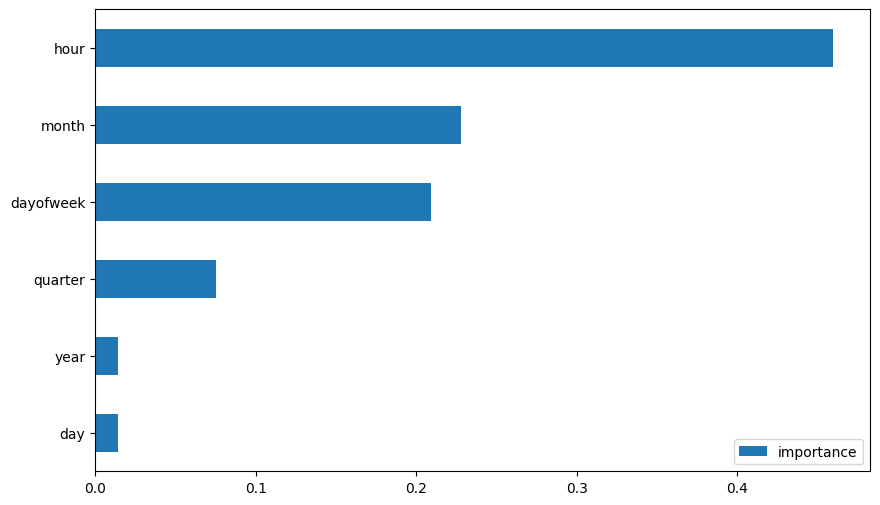

In [87]:
feature_importance.sort_values(by='importance').plot(kind='barh', figsize=(10, 6))

# 7. Model Evaluation and Forecast on test set

In [88]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how='left', left_index=True, right_index=True)

In [89]:
df.head()

,PJME_MW,hour,dayofweek,quarter,day,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,1,2002,1,1,1,NaN


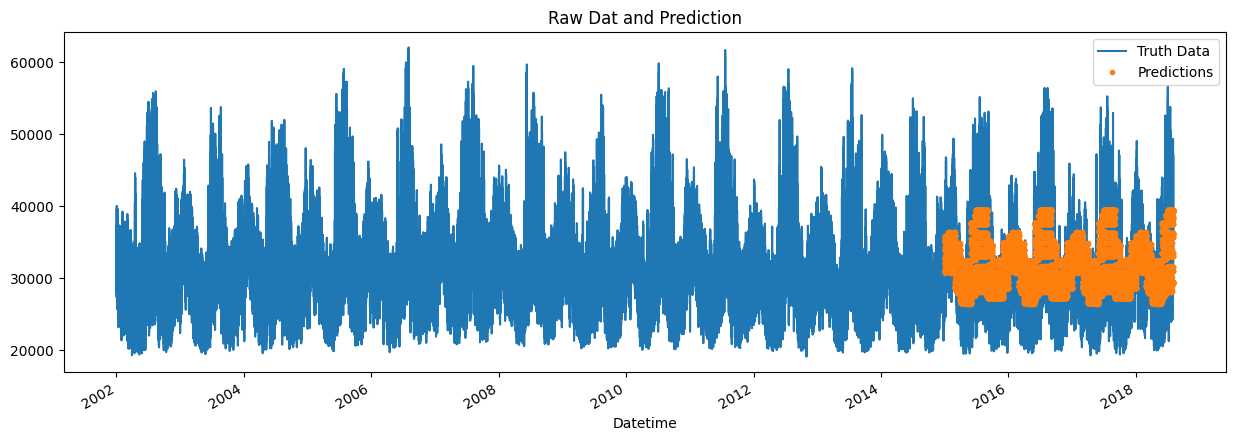

In [90]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

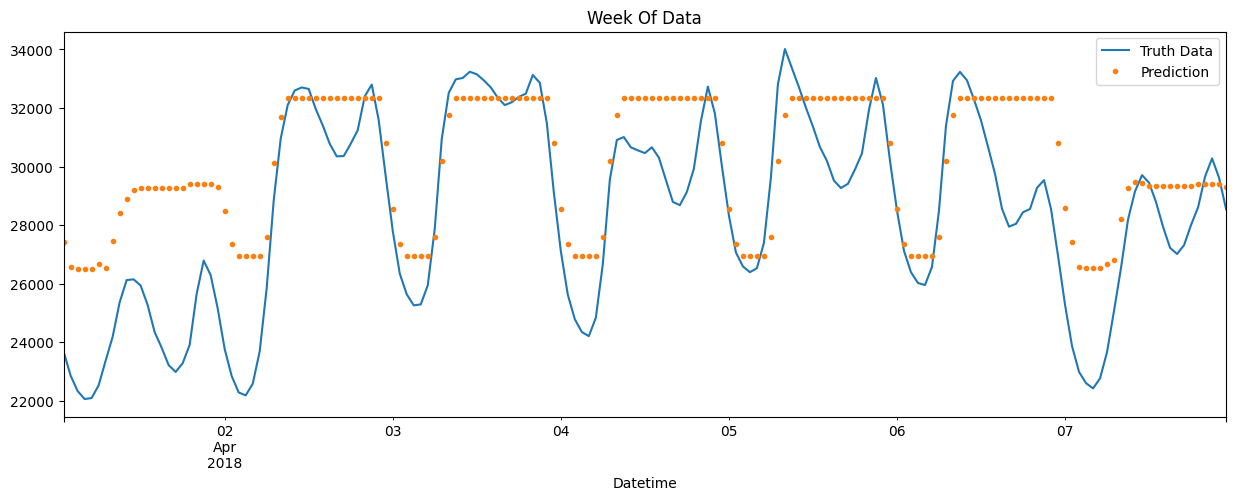

In [91]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

We could add features for specific days, holidays, or other events that might affect energy usage.
For example, we could add a feature for weekends vs. weekdays, or for holidays.
weather data could also be integrated to improve predictions, such as temperature, humidity, or precipitation.
 Additionally, we could explore more advanced models or techniques such as time series forecasting methods,

In [92]:
# Calculate root mean squared error (RMSE)
score = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE: {score:.2f}')

RMSE: 4404.43


In [93]:
# Calculate error
test['error'] = np.abs(test['prediction'] - y_test)


# Next steps could include:
- cross-validation to ensure model robustness
- add more features such as weather data, holidays, or special events

# 8. Train using cross validation

## Lag features

In [94]:
df['PJME_MW'].to_dict()


{Timestamp('2002-01-01 01:00:00'): 30393.0,
 Timestamp('2002-01-01 02:00:00'): 29265.0,
 Timestamp('2002-01-01 03:00:00'): 28357.0,
 Timestamp('2002-01-01 04:00:00'): 27899.0,
 Timestamp('2002-01-01 05:00:00'): 28057.0,
 Timestamp('2002-01-01 06:00:00'): 28654.0,
 Timestamp('2002-01-01 07:00:00'): 29308.0,
 Timestamp('2002-01-01 08:00:00'): 29595.0,
 Timestamp('2002-01-01 09:00:00'): 29943.0,
 Timestamp('2002-01-01 10:00:00'): 30692.0,
 Timestamp('2002-01-01 11:00:00'): 31395.0,
 Timestamp('2002-01-01 12:00:00'): 31496.0,
 Timestamp('2002-01-01 13:00:00'): 31031.0,
 Timestamp('2002-01-01 14:00:00'): 30360.0,
 Timestamp('2002-01-01 15:00:00'): 29798.0,
 Timestamp('2002-01-01 16:00:00'): 29720.0,
 Timestamp('2002-01-01 17:00:00'): 31271.0,
 Timestamp('2002-01-01 18:00:00'): 35103.0,
 Timestamp('2002-01-01 19:00:00'): 35732.0,
 Timestamp('2002-01-01 20:00:00'): 35639.0,
 Timestamp('2002-01-01 21:00:00'): 35285.0,
 Timestamp('2002-01-01 22:00:00'): 34007.0,
 Timestamp('2002-01-01 23:00:00'

In [95]:
def add_lags(df):
    """
    Function to add lag features to the DataFrame.
    """
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

In [96]:
# Keep all columns except 'prediction'
df = df.drop(columns=['prediction'])

In [104]:
 df.tail()

,PJME_MW,hour,dayofweek,quarter,day,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,2,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,2,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,2,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,2,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [107]:
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train = create_time_features(train)
    test = create_time_features(test)

    features = ['hour', 'dayofweek', 'quarter', 'day', 'month', 'year', 'lag1', 'lag2', 'lag3']
    target = 'PJME_MW'
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]


    reg_1 = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        learning_rate=0.01,
        max_depth=3,
        objective='reg:squarederror',
    )

    print(f'Training fold {fold}')
    fold += 1
    reg_1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg_1.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Training fold 0
[0]	validation_0-rmse:32732.29813	validation_1-rmse:31956.12901
[100]	validation_0-rmse:12534.82055	validation_1-rmse:11912.19822
[200]	validation_0-rmse:5764.04962	validation_1-rmse:5378.99412
[300]	validation_0-rmse:3907.02237	validation_1-rmse:3916.56793
[400]	validation_0-rmse:3475.74445	validation_1-rmse:3784.28982
[439]	validation_0-rmse:3416.62403	validation_1-rmse:3789.84104
Training fold 1
[0]	validation_0-rmse:32671.76899	validation_1-rmse:32142.13679
[100]	validation_0-rmse:12515.66034	validation_1-rmse:12222.86042
[200]	validation_0-rmse:5762.79809	validation_1-rmse:5667.89364
[300]	validation_0-rmse:3936.42917	validation_1-rmse:3961.34800
[400]	validation_0-rmse:3511.51248	validation_1-rmse:3636.52265
[500]	validation_0-rmse:3390.57985	validation_1-rmse:3568.05132
[600]	validation_0-rmse:3335.14626	validation_1-rmse:3541.57940
[700]	validation_0-rmse:3295.98481	validation_1-rmse:3506.94026
[800]	validation_0-rmse:3266.02963	validation_1-rmse:3486.33103
[900

In [109]:
scores

[np.float64(3781.619664996337),
 np.float64(3457.858910668395),
 np.float64(3527.239442062761),
 np.float64(4085.306097974836),
 np.float64(3940.8348924455945)]

In [131]:
# score across all folds
print(f'RMSE across all folds: {np.mean(scores):.2f} +/- {np.std(scores):.2f}')

RMSE across all folds: 3758.57 +/- 238.52


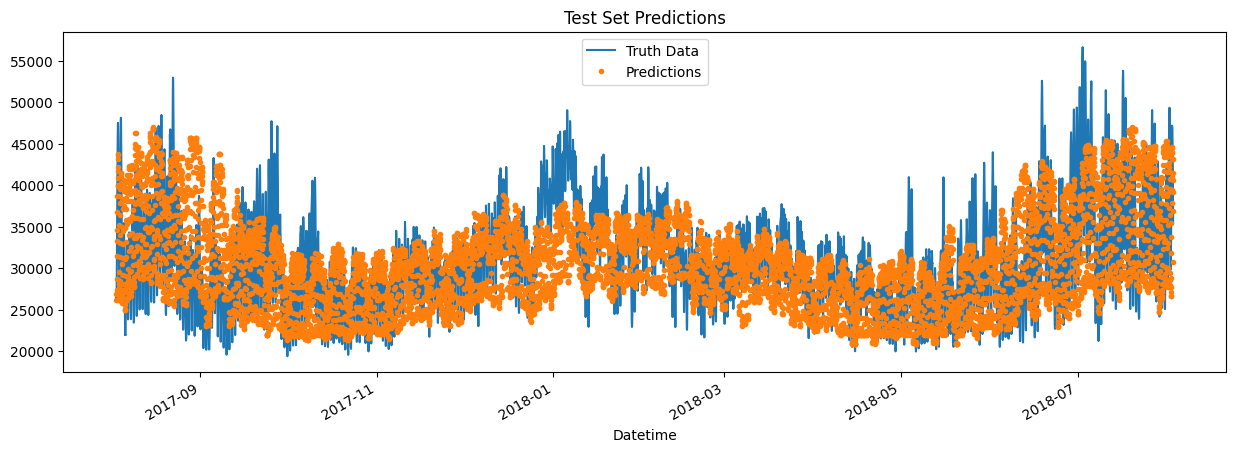

In [112]:
# show predictions and actual values
test['prediction'] = preds[-1]
ax = test['PJME_MW'].plot(figsize=(15, 5), title='Test Set Predictions')
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

In [124]:
# Show test set actuals values, predictions and error in a table
test['prediction'] = preds[-1]
test['error'] = np.abs(test['prediction'] - y_test)
test[['PJME_MW', 'prediction', 'error']].head(10)

,PJME_MW,prediction,error
Datetime,,,
2017-08-03 03:00:00,26544.0,26851.562500,307.562500
2017-08-03 04:00:00,26012.0,26193.257812,181.257812
2017-08-03 05:00:00,26187.0,26199.644531,12.644531
2017-08-03 06:00:00,27504.0,27333.105469,170.894531
2017-08-03 07:00:00,29412.0,28659.042969,752.957031
2017-08-03 08:00:00,31836.0,31413.378906,422.621094
2017-08-03 09:00:00,33967.0,33208.082031,758.917969
2017-08-03 10:00:00,36162.0,34639.085938,1522.914062
2017-08-03 11:00:00,38510.0,36766.296875,1743.703125


In [125]:
# Which dates have maximum and minimum error?
max_error_date = test['error'].idxmax()
max_error_value = test['error'].max()
min_error_date = test['error'].idxmin()
min_error_value = test['error'].min()
print(f'Maximum error on {max_error_date} with value {max_error_value}')
print(f'Minimum error on {min_error_date} with value {min_error_value}')


Maximum error on 2018-07-02 19:00:00 with value 14912.01953125
Minimum error on 2018-05-15 03:00:00 with value 0.71875


In [130]:
# Access that index
test[['PJME_MW', 'prediction', 'error']].sort_values(by='error', ascending=False).head(10)

,PJME_MW,prediction,error
Datetime,,,
2018-07-02 19:00:00,56231.0,41318.980469,14912.019531
2018-06-30 19:00:00,49031.0,34270.843750,14760.156250
2018-06-30 20:00:00,47522.0,32812.542969,14709.457031
2018-06-30 18:00:00,49341.0,34653.253906,14687.746094
2017-08-29 19:00:00,31167.0,45426.628906,14259.628906
2017-09-25 17:00:00,47697.0,33454.460938,14242.539062
2017-09-25 16:00:00,47169.0,33001.207031,14167.792969
2017-08-29 18:00:00,31502.0,45581.496094,14079.496094
2018-06-30 17:00:00,48790.0,34775.746094,14014.253906


# 9. Predicting into the future

In [132]:
# Now we train the model again using all the data and the above info
df = create_time_features(df)

features = ['hour', 'dayofweek', 'quarter', 'day', 'month', 'year', 'lag1', 'lag2', 'lag3']
target = 'PJME_MW'

# Define the features and target for the entire dataset
X_all = df[features]
y_all = df[target]

reg_final = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    objective='reg:linear',
)

reg_final.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)


[0]	validation_0-rmse:32403.51963


/Users/nikhilvinay/Documents/my_projects/learning/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [14:59:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12429.21574
[200]	validation_0-rmse:5760.76081
[300]	validation_0-rmse:3996.85535
[400]	validation_0-rmse:3605.65905
[499]	validation_0-rmse:3496.10002


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


We used n_estimators = 500 because in the cross-validation dataset trainig, the model started to overfit around 500.

In [138]:
# Predicting into the future
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_time_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [146]:
future_w_features['pred'] = reg_final.predict(future_w_features[features])


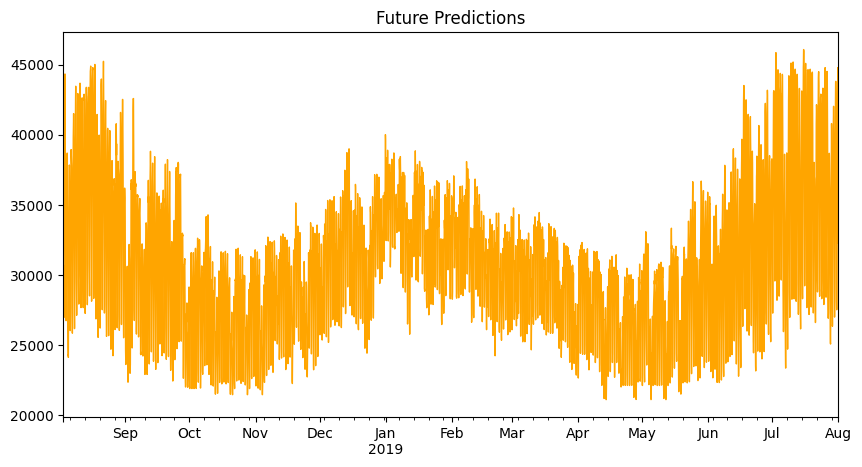

In [149]:
future_w_features['pred'].plot(figsize=(10, 5),
                                 color='orange',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Save the model

In [158]:
reg_final.save_model('model.json')

In [159]:
!ls -lh

total 17144
-rw-rw-r--  1 nikhilvinay  staff   3.2M Jul 27 19:05 AEP_hourly.csv
-rw-rw-r--  1 nikhilvinay  staff   3.9M Jul 27 18:35 PJME_hourly.csv
-rw-r--r--@ 1 nikhilvinay  staff   653K Jul 27 21:41 code.ipynb
-rw-r--r--  1 nikhilvinay  staff   557K Aug  1 15:14 model.json
-rw-r--r--  1 nikhilvinay  staff    62B Jul 27 18:38 requirements.txt


In [160]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

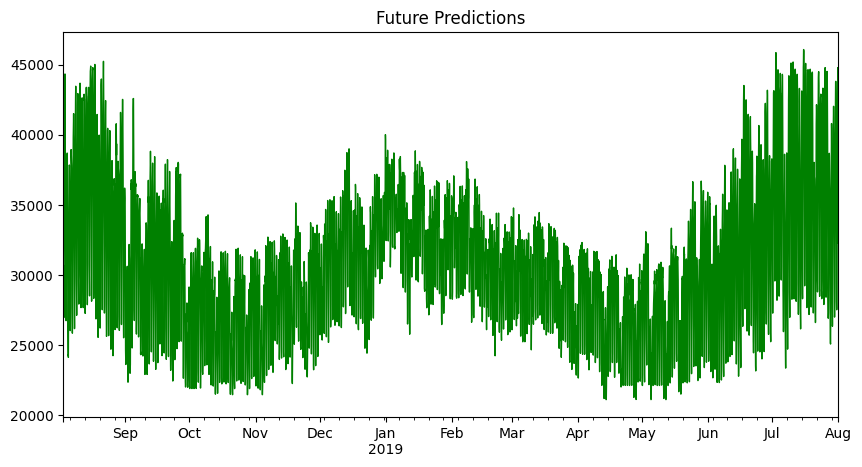

In [163]:
future_w_features['pred'] = reg_new.predict(future_w_features[features])
future_w_features['pred'].plot(figsize=(10, 5),
                               color='green',
                               ms=1, lw=1,
                               title='Future Predictions')
plt.show()